In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from scipy.stats import spearmanr


In [4]:
torch.ones(128)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])

In [15]:
embeddings = np.load('/home/jyang4/ProtTP/saved/AE/embeddings.npy')
embeddings.shape

(149361, 32)

In [2]:
ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")
FILEPATH = './data/AllPredictions.csv'
dataframe = pd.read_csv(FILEPATH)

In [3]:
class GB1Dataset(Dataset):
    
    def __init__(self, dataframe):
        full_sequence = False
        
        self.data = dataframe
        self.data['num_muts'] = self.data['Combo'].apply(self.diff_letters)

        #only select variants with 2 or less mutations
        #self.data = self.data[self.data['num_muts'] <= 2]
        
        self.all_combos = self.data["Combo"]
        if full_sequence:
            self.all_combos = self.all_combos.apply(self.generate_full) #need to fix this
        self.n_positions_combined = len(self.all_combos[0])

        self.X = torch.tensor(self._generate_onehot()).float()
        self.attributes = self.data[["Triad-FixedBb-dG", "EvMutation"]].values #,"EvMutation", "esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked", "esm_msa1_t12_100M_UR50S-Conditional-ColumnUnmasked","Triad-FlexibleBb-dG", "Triad-FlexibleBb-RMSD"]].values
        scaler = StandardScaler()
        self.attributes = scaler.fit_transform(self.attributes)
        self.attributes = torch.tensor(self.attributes).float()
        
        
        # , ,	"esm_msa1_t12_100M_UR50S-Conditional-ColumnUnmasked", "esm_msa1_t12_100M_UR50S-Naive-ColumnMasked", "esm_msa1_t12_100M_UR50S-Conditional-ColumnMasked"]].values
        
        self.y = self.data["Fitness"].values

    #function that generates onehot encodings
    def _generate_onehot(self):
        """
        Builds a onehot encoding for a given combinatorial space.
        """
        # Make a dictionary that links amino acid to index
        one_hot_dict = {aa: i for i, aa in enumerate(ALL_AAS)}
    
        # Build an array of zeros
        onehot_array = np.zeros([len(self.all_combos), self.n_positions_combined, 20])
        
        # Loop over all combos. This should all be vectorized at some point.
        for i, combo in enumerate(self.all_combos):
            
            # Loop over the combo and add ones as appropriate
            for j, character in enumerate(combo):
                
                # Add a 1 to the appropriate position
                onehot_ind = one_hot_dict[character]
                onehot_array[i, j, onehot_ind] = 1
                
        # Return the flattened array
        return onehot_array.reshape(onehot_array.shape[0],-1)
    
    @staticmethod
    def diff_letters(a, b = 'VDGV'):
        return sum ( a[i] != b[i] for i in range(len(a)) )

    @staticmethod
    def generate_full(combo):
        seq = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
        seq = seq[:38] + combo[0] + combo[1] + combo[2] + seq[41:53] + combo[3] + seq[54:]
        return seq
          
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):            
        return self.X[index], self.attributes[index]

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.cuda.device_count()
cuda0 = torch.cuda.set_device(0)

# Hyper-parameters
h_dim1 = 64 #hidden layer dimension 1
h_dim2 = 40 #hidden layer dimension 2
z_dim = 32 #embedding dimension
attr_dim = 2 #number of attributes to decode
num_epochs = 20

#h_dim1 = 512 #hidden layer dimension 1
#h_dim2 = 256 #hidden layer dimension 2
#z_dim = 128 #embedding dimension

batch_size = 128
learning_rate = 1e-3
variational = True #if True, trains a variational autoencoder instead of an autoencoder
attributes = True #if True, incorporates task programming via an attribute decoding loss

# GB1 dataset
dataset = GB1Dataset(dataframe)
input_dim = dataset.n_positions_combined*20 #initial dimension

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# VAE/AE model
class ProtTP(nn.Module):
    def __init__(self, input_dim=80, h_dim1=64, h_dim2=40, z_dim=32, attr_dim =2, 
            variational=True, attributes = True):
        super(ProtTP, self).__init__()

        #encoder layers
        self.fce1 = nn.Linear(input_dim, h_dim1)
        self.fce2 = nn.Linear(h_dim1, h_dim2)
        self.fce3 = nn.Linear(h_dim2, z_dim)
        self.fcvar = nn.Linear(h_dim2, z_dim)
        
        #decoder layers
        self.fcd1 = nn.Linear(z_dim, h_dim2)
        self.fcd2 = nn.Linear(h_dim2, h_dim1)
        self.fcd3 = nn.Linear(h_dim1, input_dim)

        #attribute decoder layers
        self.fcad1 = nn.Linear(z_dim, z_dim)
        self.fcad2 = nn.Linear(z_dim, attr_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fce1(x))
        h2 = F.relu(self.fce2(h1))
        if variational:
            return self.fce3(h2), self.fcvar(h2)
        else:
            return self.fce3(h2)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h1 = F.relu(self.fcd1(z))
        h2 = F.relu(self.fcd2(h1))
        return torch.sigmoid(self.fcd3(h2))
    
    def decode_attr(self, z):
        h1 = F.relu(self.fcad1(z))
        return self.fcad2(z)

    def forward(self, x):
        if variational:
            mu, log_var = self.encode(x)
            z = self.reparameterize(mu, log_var)
            x_reconst = self.decode(z)
            if attributes:
                attr_reconst = self.decode_attr(z)
                return x_reconst, mu, log_var, attr_reconst
            else:
                return x_reconst, mu, log_var
        else:
            z = self.encode(x)
            x_reconst = self.decode(z)
            if attributes:
                attr_reconst = self.decode_attr(z)
                return x_reconst, z, attr_reconst
            else:
                return x_reconst, z
        
model = ProtTP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda


In [11]:
# Start training
best_loss = 0
for epoch in range(num_epochs):
    for i, (x, a) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, input_dim)
        a = a.to(device)#.view(-1, input_dim)

        if variational:
            if attributes:
                x_reconst, mu, log_var, attr_reconst = model(x)
                attr_loss = F.mse_loss(attr_reconst, a)
            else:
                x_reconst, mu, log_var = model(x)
                attr_loss = 0
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) 
        else:
            if attributes:
                x_reconst, z, attr_reconst = model(x)
                attr_loss = F.mse_loss(attr_reconst, a)
            else:
                x_reconst, z = model(x)
                attr_loss = 0
            kl_div = 0
        
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        loss = reconst_loss*0.1 + kl_div + attr_loss*10000
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print ("Epoch[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Attribute Loss: {:.4f}" 
        .format(epoch+1, num_epochs, reconst_loss, kl_div, attr_loss))
    
    #update the best model after each epoch
    if epoch == 0 or loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_AE.pth')
        print('Best model saved')

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Reconst Loss: 1692.2592, KL Div: 549.7090, Attribute Loss: 0.0212
Best model saved
Epoch[2/20], Reconst Loss: 1619.2917, KL Div: 489.8745, Attribute Loss: 0.0156
Best model saved
Epoch[3/20], Reconst Loss: 1600.2013, KL Div: 503.3268, Attribute Loss: 0.0165
Epoch[4/20], Reconst Loss: 1617.1465, KL Div: 513.9342, Attribute Loss: 0.0158
Epoch[5/20], Reconst Loss: 1596.9092, KL Div: 504.9936, Attribute Loss: 0.0158
Epoch[6/20], Reconst Loss: 1596.7355, KL Div: 502.3895, Attribute Loss: 0.0142
Best model saved
Epoch[7/20], Reconst Loss: 1591.9559, KL Div: 514.5820, Attribute Loss: 0.0180
Epoch[8/20], Reconst Loss: 1594.4209, KL Div: 516.6362, Attribute Loss: 0.0136
Epoch[9/20], Reconst Loss: 1577.9397, KL Div: 486.7364, Attribute Loss: 0.0169
Epoch[10/20], Reconst Loss: 1599.5208, KL Div: 489.2451, Attribute Loss: 0.0150
Best model saved
Epoch[11/20], Reconst Loss: 1569.7588, KL Div: 499.8595, Attribute Loss: 0.0134
Best model saved
Epoch[12/20], Reconst Loss: 1600.4773, KL Di

In [137]:
#Get embeddings
model.load_state_dict(torch.load('./saved/AE+AD/best.pth'))

with torch.no_grad():
    X = dataset.X.to(device)
    if variational:
        mu, log_var = model.encode(X)
        embeddings = model.reparameterize(mu, log_var)
    else:
        embeddings = model.encode(X)
    reconstructions = model.decode(embeddings)

In [139]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(embeddings.cpu())
dataframe[['PCA 1', 'PCA 2']] = transformed

#plot the high fitness values last
dataframe = dataframe.sort_values('Fitness')

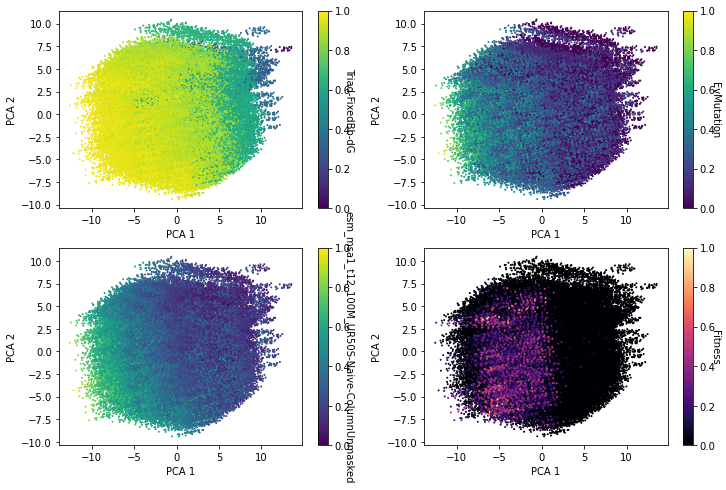

In [140]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, attribute in enumerate(['Triad-FixedBb-dG', 'EvMutation', 'esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked', 'Fitness']):
    ax = axs.reshape(-1)[i]
    if i == 3:
        color = 'magma'
    else:
        color = 'viridis'
    
    ax.scatter(data=dataframe, x='PCA 1', y='PCA 2', s=1, c=attribute, cmap=color)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=color), ax=ax)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    cbar.set_label(attribute, rotation=270)

plt.savefig('Autoencoder+AttributeDecoder.jpg')

In [160]:
model_params = {"booster": "gbtree",
                      "tree_method": "exact",
                      "nthread": 1,
                      "objective": "reg:tweedie",
                      "tweedie_variance_power": 1.5,
                      "eval_metric": "tweedie-nloglik@1.5"}

# model_params = {"booster": "gblinear",
#                       "tree_method": "exact",
#                       "nthread": 1,
#                       "verbosity": 0,
#                       "objective": "reg:tweedie",
#                       "tweedie_variance_power": 1.5,
#                       "eval_metric": "tweedie-nloglik@1.5"}

In [168]:
#downstream supervised regression
N_models = 500
N_train_samples = 384
N_test_samples = 96
alpha = 1
linear = False

X_baseline = np.array(dataset.X)
X_OHembed = np.concatenate((np.array(dataset.X), np.array(embeddings.cpu())), axis=1)
X_embed = np.array(embeddings.cpu())
X_zs = np.concatenate((np.array(dataset.X), np.array(dataset.attributes)), axis=1)
X_all = np.concatenate((np.array(dataset.X), np.array(dataset.attributes), np.array(embeddings.cpu())), axis=1)
#X_zs = np.array(dataset.attributes)

inputs = [X_baseline, X_embed,X_OHembed, X_zs, X_all]
#inputs = [X_baseline, X_zs]

results = np.zeros((N_models, len(inputs)*2))
for j, X in enumerate(inputs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = dataset.y

    X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    np.random.seed(42)
    for i in range(N_models):
        X_train, y_train = resample(X_train_all, y_train_all, n_samples=N_train_samples)
        #only run this line if you wish to use a different test size
        #X_test, y_test = resample(X, y, n_samples=N_test_samples)
        
        if linear:
            clf = Ridge(alpha=alpha)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
        else:
            #insert kfold cross validation
            train_matrix = xgb.DMatrix(X_train, label = y_train)
            test_matrix = xgb.DMatrix(X_test, label = y_test)
            evallist = [(train_matrix, "train"), (test_matrix, "test")]
            bst = xgb.train(model_params, train_matrix, evals=evallist, verbose_eval=False)
            best = bst.best_ntree_limit #bst.best_iteration
            print(best)
            y_pred_test = bst.predict(xgb.DMatrix(X_test), iteration_range=(0,best))
        
        results[i, j] = ndcg_score([y_test], [y_pred_test])
        results[i, len(inputs)+j] = spearmanr(y_test, y_pred_test)[0]

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


KeyboardInterrupt: 

/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtTP/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


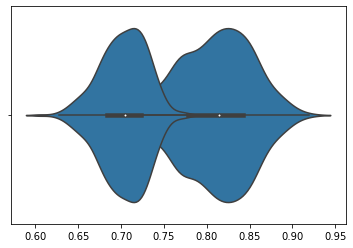

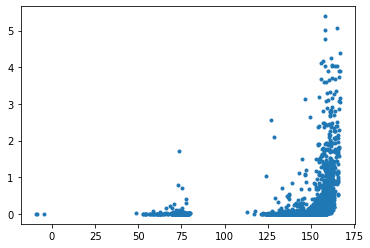

In [8]:
data = dataset.data
#scores = data["EvMutation"]#[:100]
all_scores = data["Triad-FixedBb-dG"]#[:32000]
#all_scores = data["esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked"]
all_fitness = data['Fitness']#[:100]

ndcgs = []
rhos = []
for i in range(N_models):
    scores, fitness = resample(all_scores, all_fitness, n_samples=N_train_samples)
    ndcgs.append(ndcg_score([fitness], [scores]))
    rhos.append(spearmanr(fitness, scores)[0])
ax = sns.violinplot(ndcgs)
ax = sns.violinplot(rhos)

plt.figure()
plt.plot(all_scores, all_fitness, '.')

OH NDCG          0.863566
AE NDCG          0.812689
OH+AE NDCG       0.869774
OH+ZS NDCG       0.864206
OH+AE+ZS NDCG    0.869666
OH rho           0.716656
 AE rho          0.709524
OH+AE rho        0.719232
OH+ZS rho        0.718085
OH+AE+ZS rho     0.718927
dtype: float64


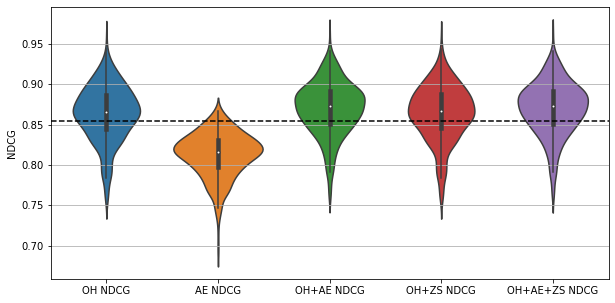

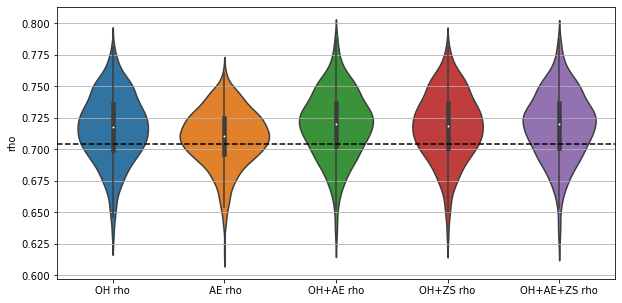

In [9]:
#increasing the NDCG increase ridge model performance
results = pd.DataFrame(data=results, columns= ['OH NDCG', 'AE NDCG', 'OH+AE NDCG', 'OH+ZS NDCG', 'OH+AE+ZS NDCG', 'OH rho',' AE rho', 'OH+AE rho', 'OH+ZS rho', 'OH+AE+ZS rho'])

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = results.iloc[:,:len(inputs)])
plt.axhline(y = ndcg_score([all_fitness], [all_scores]), color = 'k', linestyle = '--')
plt.ylabel('NDCG')

plt.figure(figsize=(10,5))
plt.grid()
ax = sns.violinplot(data = results.iloc[:,len(inputs):])
plt.axhline(y = spearmanr(all_fitness, all_scores)[0], color = 'k', linestyle = '--')
plt.ylabel('rho')

print(np.mean(results, axis =0))


Text(336.9714285714286, 0.5, 'Actual fitness')

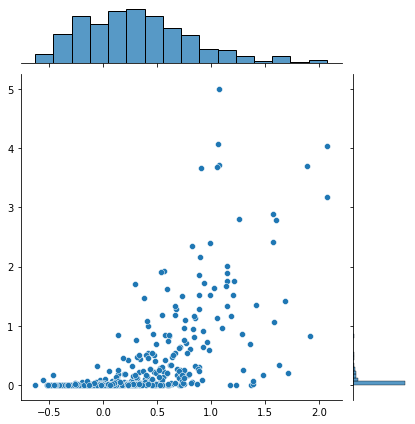

In [266]:
ax = sns.jointplot(x = y_pred_test,y = y_test)
plt.xlabel('Predicted fitness')
plt.ylabel('Actual fitness')

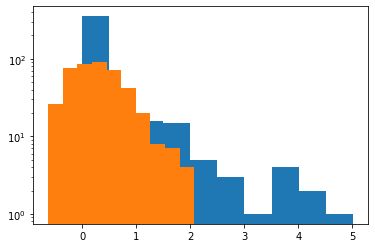

In [267]:
plt.hist(y_test)
plt.hist(y_pred_test)
plt.yscale('log')